In [3]:
import pandas as pd
import numpy as np
from pycaret.clustering import *
import matplotlib.pyplot as plt

In [194]:
!pip list

Package                   Version        Editable project location
------------------------- -------------- ------------------------------------------------------------------------
antlr4-python3-runtime    4.9.3
anyconfig                 0.10.1
anyio                     4.9.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.3
binaryornot               0.4.4
bleach                    6.2.0
blinker                   1.9.0
build                     1.2.2.post1
cachetools                5.5.2
category-encoders         2.6.4
certifi                   2025.1.31
cffi                      1.17.1
chardet                   5.2.0
charset-normalizer        3.4.1
click                     8.1.8
cloudpickle               3.1.1
comm                      0.2.2
contourpy                 1.3.0
co

In [4]:
train_data = pd.read_parquet("../data/05_model_input/selected_train_data.parquet")

In [5]:
train_data.columns

Index(['gender', 'age', 'NumberOffriends', 'basketball', 'football', 'soccer',
       'softball', 'volleyball', 'swimming', 'cheerleading', 'baseball',
       'tennis', 'sports', 'cute', 'sexy', 'hot', 'dance', 'band', 'marching',
       'music', 'rock', 'church', 'hair', 'dress', 'mall', 'shopping',
       'clothes', 'hollister', 'abercrombie', 'die', 'death', 'drunk',
       'drugs'],
      dtype='object')

In [108]:
train_data.shape

(9429, 33)

In [109]:
exp = setup(data=train_data, normalize=False, session_id=123)

,Description,Value
0,Session id,123
1,Original data shape,"(9429, 33)"
2,Transformed data shape,"(9429, 33)"
3,Numeric features,33
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [110]:
modelos_disponibles = models()

In [111]:
modelos_disponibles.index

Index(['kmeans', 'ap', 'meanshift', 'sc', 'hclust', 'dbscan', 'optics',
       'birch'],
      dtype='object', name='ID')

In [112]:
# Utilizo modelos que tengan método predict para asignar a un clúster en tiempo real

modelos_a_utilizar = modelos_disponibles.loc[['kmeans', 'birch'], :]

resultados = []
modelos_entrenados = {}

for idx in modelos_a_utilizar.index:
    modelo_id = modelos_a_utilizar.loc[idx, 'Name']
    print(f"Entrenando modelo: {modelo_id} ...")
    
    modelo = create_model(idx)
    modelos_entrenados[modelo_id] = modelo
    # pull() recupera la última tabla de métricas mostrada por PyCaret
    df_res = pull().copy()
    # Añadimos el nombre del modelo a las métricas
    df_res['Modelo'] = modelo_id
    resultados.append(df_res)

Entrenando modelo: K-Means Clustering ...


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3294,8415.1875,1.1061,0,0,0


Entrenando modelo: Birch Clustering ...


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3937,3326.1609,0.6207,0,0,0


In [113]:
modelos_entrenados

{'K-Means Clustering': KMeans(n_clusters=4, random_state=123),
 'Birch Clustering': Birch(n_clusters=4)}

# Optimización de hiperparámetros

## K-Means

In [183]:
def optimizacion_kmeans(setup, range_k=list(range(2,21))):
    """
    Optimiza hiperparámetros para K-Means sobre el conjunto 'data'.
    
    Parámetros:
      - data: DataFrame con los datos.
      - range_k: Lista con los valores de k (número de clusters) a probar.
      - session_id: Entero para reproducibilidad en PyCaret.
      
    Retorna:
      - DataFrame con las métricas internas (Silueta, Calinski-Harabasz, Davies-Bouldin)
        y la configuración usada.
    """    
    resultados = []
    
    for k in range_k:
        # Entrena K-Means con num_clusters = k
        modelo = create_model('kmeans', num_clusters=k)
        # Obtén la tabla de métricas generada por PyCaret
        df_metrics = pull().copy()
        df_metrics['model'] = 'kmeans'
        df_metrics['k'] = k
        resultados.append(df_metrics)
    
    df_final = pd.concat(resultados, ignore_index=True)
    return df_final

In [184]:
df_kmeans = optimizacion_kmeans(exp)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4869,0.7897,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3932,10134.1481,0.9133,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3294,8415.1875,1.1061,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3872,8761.1166,0.9233,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4113,8904.9857,0.8042,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4076,8141.2708,0.7828,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3701,8082.9275,0.8719,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3692,7686.2658,0.8639,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3475,7632.6681,0.9071,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3496,7458.1772,0.8710,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3129,7090.2872,0.9786,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3003,6680.2564,1.0116,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2968,6361.7109,1.0169,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2889,6032.8640,1.2426,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2680,5898.2242,1.2754,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2626,5578.1665,1.3712,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2661,5458.1360,1.2808,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2630,5253.4296,1.2760,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2447,5066.6977,1.3391,0,0,0


In [185]:
print(df_kmeans[['model', 'k', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']].sort_values(by='Silhouette', ascending=False))

     model   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   kmeans   2      0.4730         11498.4869          0.7897
4   kmeans   6      0.4113          8904.9857          0.8042
5   kmeans   7      0.4076          8141.2708          0.7828
1   kmeans   3      0.3932         10134.1481          0.9133
3   kmeans   5      0.3872          8761.1166          0.9233
6   kmeans   8      0.3701          8082.9275          0.8719
7   kmeans   9      0.3692          7686.2658          0.8639
9   kmeans  11      0.3496          7458.1772          0.8710
8   kmeans  10      0.3475          7632.6681          0.9071
2   kmeans   4      0.3294          8415.1875          1.1061
10  kmeans  12      0.3129          7090.2872          0.9786
11  kmeans  13      0.3003          6680.2564          1.0116
12  kmeans  14      0.2968          6361.7109          1.0169
13  kmeans  15      0.2889          6032.8640          1.2426
14  kmeans  16      0.2680          5898.2242          1.2754
16  kmea

In [186]:
mejor_modelo = create_model('kmeans', num_clusters=2)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4869,0.7897,0,0,0


In [187]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_data)

In [189]:
train_data.shape

(9429, 33)

In [190]:
mejor_modelo

KMeans(n_clusters=2, random_state=123)

In [188]:
clusters_train = mejor_modelo.predict(train_data)

df_pca = pd.DataFrame(train_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters_train

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('Visualización de Clusters con PCA')
plt.show()

ValueError: Buffer dtype mismatch, expected 'const double' but got 'float'

In [180]:
def optimizacion_birch(setup, range_k=list(range(2, 21, 2)), birch_thresholds=[0.3, 0.5]):
    """
    Optimiza hiperparámetros para Birch sobre el conjunto 'data'.
    
    Parámetros:
      - data: DataFrame con los datos.
      - range_k: Lista con los valores de k (número de clusters) a probar.
      - birch_thresholds: Lista de valores para el parámetro 'threshold' de Birch.
      - session_id: Entero para reproducibilidad en PyCaret.
      
    Retorna:
      - DataFrame con las métricas internas (Silueta, Calinski-Harabasz, Davies-Bouldin)
        y la configuración usada.
    """
    
    resultados = []
    
    for k in range_k:
        for thr in birch_thresholds:
            # Entrena Birch con num_clusters = k y threshold = thr
            modelo = create_model('birch', num_clusters=k, threshold=thr)
            df_metrics = pull().copy()
            df_metrics['model'] = 'birch'
            df_metrics['k'] = k
            df_metrics['threshold'] = thr
            resultados.append(df_metrics)
    
    df_final = pd.concat(resultados, ignore_index=True)
    return df_final

In [119]:
df_birch = optimizacion_birch(setup, birch_thresholds=np.linspace(0.1, 1.0, 20))

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4722,11264.2390,0.7808,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4674,10389.8925,0.7747,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3994,5205.9765,0.7649,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4345,7650.5816,0.7579,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4377,8673.7788,0.8290,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3376,5926.5881,0.8626,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3410,6559.6318,0.9049,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3846,8504.4492,0.9406,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4638,205.2706,0.6343,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3490,5591.5558,0.8429,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3966,276.0089,0.6383,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4231,6759.5558,0.7559,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4665,11223.4971,0.7932,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3462,5114.1032,0.8202,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5452,133.8706,0.5523,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5116,430.5961,0.5746,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5946,288.9762,0.4603,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4498,11100.5258,0.8332,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4498,11100.5258,0.8332,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4231,8247.9302,0.8022,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2439,7453.7058,1.1834,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2847,7034.1175,1.0812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2858,7755.0375,1.1108,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3105,5295.7653,0.8792,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3584,6570.1135,0.8759,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2458,2714.9777,0.7458,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3302,3204.0230,0.7739,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3820,3378.2281,0.6570,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3238,2075.9712,0.6989,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3586,3684.2596,0.6741,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3928,2425.3589,0.6163,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4301,4117.0819,0.6672,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3271,1891.5899,0.6482,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4353,4200.1761,0.6588,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3995,4000.5360,0.7411,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3676,7905.6124,0.8758,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3390,7829.3451,0.9639,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2960,7466.8278,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3424,6940.3004,0.8300,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2402,4274.3404,1.0230,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2644,4952.9175,0.9862,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2218,3647.6745,1.0141,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2768,3263.7181,1.3492,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3401,3659.3151,0.7900,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3658,3978.2408,0.6904,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3319,3699.2905,0.8235,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3348,3443.9253,0.6651,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3602,3838.6807,0.7167,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3507,3552.4232,0.6666,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4218,2528.8136,0.6628,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3113,7419.4582,0.9476,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3215,7237.5622,0.9282,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3239,6806.3940,0.8664,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3643,6484.9172,0.7737,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3261,5821.5317,0.8488,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3484,6260.5220,0.7985,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2875,4218.9427,0.9550,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1712,2392.6829,1.3671,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3087,2699.2078,0.8366,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3437,2884.7439,0.8328,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3184,2659.3695,0.8215,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3705,4044.9180,0.6989,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3509,3463.3693,0.7831,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3410,4765.5101,0.7610,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3308,3882.5438,0.8675,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2914,6804.9927,0.9620,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3287,6728.7768,0.8514,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3289,6203.7434,0.8262,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3263,5879.7117,0.8300,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3035,5712.6680,0.8629,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3470,6326.6210,0.8433,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2844,3345.1467,1.1279,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1691,1869.2668,1.2788,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2989,2108.7019,0.8775,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3872,3781.9802,0.8283,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3530,3187.1376,0.7433,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3586,3494.1674,0.7369,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3515,3286.3103,0.8503,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2676,4090.9396,0.9384,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3015,3508.9555,1.0154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2715,6310.6486,1.0210,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2786,6102.7325,0.9359,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2975,6341.2472,0.9207,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2636,5826.3355,0.9715,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2917,6234.9049,0.9180,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3323,5522.1886,1.0948,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2848,2751.4355,1.0509,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1639,1771.5611,1.2901,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3662,2547.4999,1.0311,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3887,3583.3674,0.8013,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3898,3412.4186,0.6949,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3482,2900.4768,0.7757,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4153,3767.2556,0.8073,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2127,3935.5752,0.9893,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3015,3508.9555,1.0154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,5781.6482,1.0471,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2445,5759.7040,1.0323,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2814,5705.2035,1.2028,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2308,5664.1615,1.1464,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2924,5349.6251,1.0376,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3323,4706.2948,1.0469,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2851,2349.0821,1.1116,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1619,1505.3145,1.1984,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3992,2858.5566,0.9859,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3868,3039.4499,0.6926,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3884,3438.4150,0.6833,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4011,4671.8561,0.7647,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4084,4643.6681,0.7977,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2127,3935.5752,0.9893,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3015,3508.9555,1.0154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2330,5395.4227,1.1049,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2325,5283.1014,1.3040,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2511,5216.0724,1.2637,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2284,5251.9503,1.1047,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2923,4675.5017,0.9667,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3325,4127.3281,1.0215,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2854,2048.0880,1.1036,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2325,1849.6872,1.0929,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3762,3355.1532,0.8898,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3830,3794.2816,0.7154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3552,4745.3970,0.7433,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3497,4517.2059,0.8295,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3720,4640.0332,0.8549,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2127,3935.5752,0.9893,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3015,3508.9555,1.0154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2032,5033.1447,1.2752,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2181,4875.7856,1.3496,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2433,4813.8406,1.2469,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2250,4707.8722,1.1186,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2896,4177.1054,1.1229,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3316,3669.8930,1.1490,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3079,2452.9994,1.0717,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3209,2483.3003,1.1708,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3760,2963.9668,0.7812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3617,4026.5315,0.7483,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3502,4459.8246,0.8155,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3473,4384.6400,0.8649,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3720,4640.0332,0.8549,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2127,3935.5752,0.9893,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3015,3508.9555,1.0154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1994,4648.9212,1.2887,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2075,4575.9144,1.3436,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2423,4399.6986,1.3009,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2274,4314.4867,1.2820,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2835,3837.4707,1.0843,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3307,3310.3966,1.2654,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3291,3288.4652,1.0554,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3141,2230.8826,1.1390,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3742,2936.1572,0.7234,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3347,4089.3611,0.8262,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3502,4459.8246,0.8155,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3473,4384.6400,0.8649,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3720,4640.0332,0.8549,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2127,3935.5752,0.9893,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3015,3508.9555,1.0154,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,4149.0159,0.9423,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3290,5427.8647,0.9560,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3351,7747.6624,1.0638,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4730,11498.4634,0.7895,0,0,0


In [120]:
df_birch[['model', 'k', 'threshold', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']]

,model,k,threshold,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,birch,2,0.100000,0.4722,11264.2390,0.7808
1,birch,2,0.147368,0.4674,10389.8925,0.7747
2,birch,2,0.194737,0.3994,5205.9765,0.7649
3,birch,2,0.242105,0.4345,7650.5816,0.7579
4,birch,2,0.289474,0.4377,8673.7788,0.8290
...,...,...,...,...,...,...
195,birch,20,0.810526,0.3178,4149.0159,0.9423
196,birch,20,0.857895,0.3290,5427.8647,0.9560
197,birch,20,0.905263,0.3351,7747.6624,1.0638
198,birch,20,0.952632,0.3351,7747.6624,1.0638


In [135]:
sorted_df_birch = df_birch.sort_values(by='Silhouette', ascending=False)

In [153]:
sorted_df_birch.head(20)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,model,k,threshold
16,0.5946,288.9762,0.4603,0,0,0,birch,2,0.857895
14,0.5452,133.8706,0.5523,0,0,0,birch,2,0.763158
15,0.5116,430.5961,0.5746,0,0,0,birch,2,0.810526
199,0.4730,11498.4634,0.7895,0,0,0,birch,20,1.000000
179,0.4730,11498.4634,0.7895,0,0,0,birch,18,1.000000
159,0.4730,11498.4634,0.7895,0,0,0,birch,16,1.000000
139,0.4730,11498.4634,0.7895,0,0,0,birch,14,1.000000
119,0.4730,11498.4634,0.7895,0,0,0,birch,12,1.000000
99,0.4730,11498.4634,0.7895,0,0,0,birch,10,1.000000
79,0.4730,11498.4634,0.7895,0,0,0,birch,8,1.000000


In [125]:
model, k, threshold = sorted_df_birch.iloc[0, -3:] # Primera fila de la tabla de hiperparámetros organizadas de forma descendente. Los últimos tres valores son los hiperparámetros

In [138]:
print(model, k, threshold)

birch 2 0.8578947368421053


In [140]:
exp_optimization = setup(data=train_data, normalize=False, session_id=123)
mejor_modelo = create_model('birch', num_clusters=k, threshold=threshold)

,Description,Value
0,Session id,123
1,Original data shape,"(9429, 33)"
2,Transformed data shape,"(9429, 33)"
3,Numeric features,33
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5946,288.9762,0.4603,0,0,0


In [141]:
save_model(mejor_modelo, '../data/06_models/best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['gender', 'age', 'NumberOffriends',
                                              'basketball', 'football', 'soccer',
                                              'softball', 'volleyball',
                                              'swimming', 'cheerleading',
                                              'baseball', 'tennis', 'sports',
                                              'cute', 'sexy', 'hot', 'dance',
                                              'band', 'marching', 'music',
                                              'rock', 'church', 'hair', 'dress',
                                              'mall', 'shopping', 'clothes',
                                              'hollister', 'abercrombie', 'die', ...],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  Transfor

In [144]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from pycaret.clustering import predict_model
val_data = pd.read_parquet("../data/05_model_input/selected_val_data.parquet")

In [146]:
predicciones_val = predict_model(mejor_modelo, data=val_data)

print(predicciones_val[['Cluster']].value_counts())

Cluster  
Cluster 0    2354
Cluster 1       4
Name: count, dtype: int64


In [147]:
labels_val = predicciones_val['Cluster']

silhouette = silhouette_score(val_data, labels_val)
calinski = calinski_harabasz_score(val_data, labels_val)
davies = davies_bouldin_score(val_data, labels_val)

print(f"Silueta: {silhouette}, Calinski-Harabasz: {calinski}, Davies-Bouldin: {davies}")

Silueta: 0.5795916001441808, Calinski-Harabasz: 41.453665411488565, Davies-Bouldin: 0.49724566684841986


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

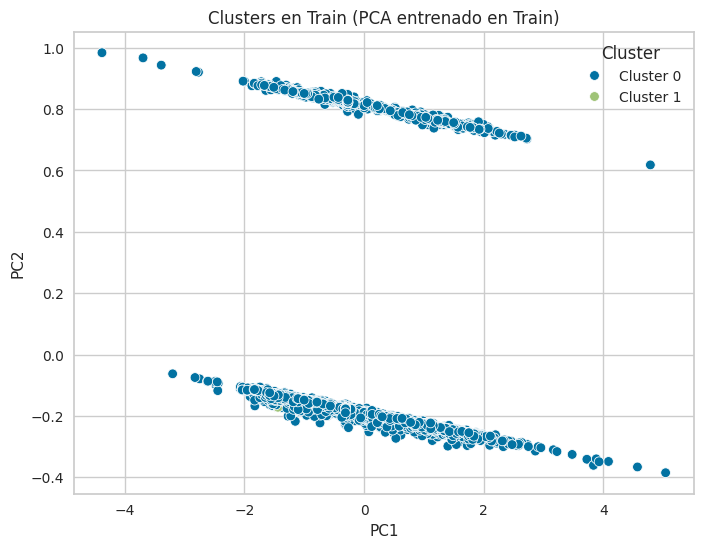

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

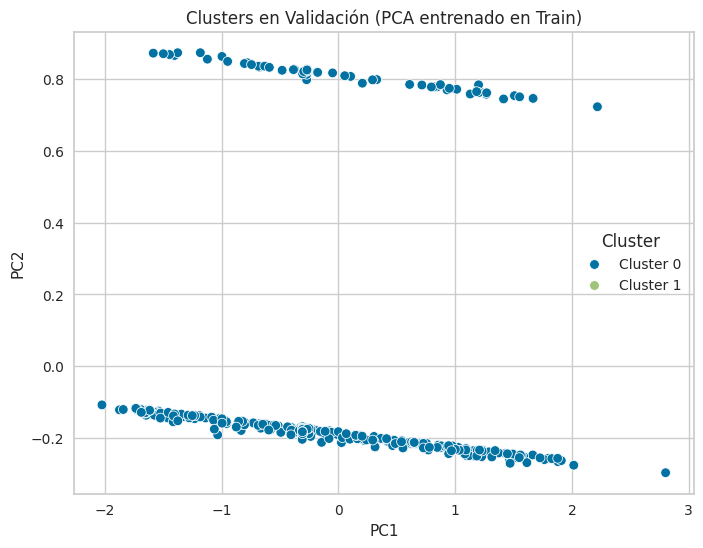

In [152]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_data) 

val_pca = pca.transform(val_data)

train_pca_df = pd.DataFrame(train_pca, columns=['PC1', 'PC2'])
val_pca_df = pd.DataFrame(val_pca, columns=['PC1', 'PC2'])

train_pca_df['Cluster'] = predict_model(mejor_modelo, data=train_data)['Cluster']
val_pca_df['Cluster'] = predict_model(mejor_modelo, data=val_data)['Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Cluster')
plt.title('Clusters en Train (PCA entrenado en Train)')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=val_pca_df, x='PC1', y='PC2', hue='Cluster')
plt.title('Clusters en Validación (PCA entrenado en Train)')
plt.show()


In [1]:
import pickle

# Cargar el modelo desde el archivo .pkl
with open("../data/06_models/best_model_birch.pkl", "rb") as file:
    modelo = pickle.load(file)

In [2]:
modelo

array(['gender', 'age', 'NumberOffriends', 'basketball', 'football',
       'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
       'baseball', 'tennis', 'sports', 'cute', 'sexy', 'hot', 'dance',
       'band', 'marching', 'music', 'rock', 'church', 'hair', 'dress',
       'mall', 'shopping', 'clothes', 'hollister', 'abercrombie', 'die',
       'death', 'drunk', 'drugs'], dtype=object)